[*********************100%***********************]  1 of 1 completed
c:\Users\oguz\Desktop\LTSM\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 7s 46ms/step - loss: 0.0118 - val_loss: 0.0014
Epoch 2/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 7.0132e-04 - val_loss: 0.0013
Epoch 3/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 6.2096e-04 - val_loss: 0.0025
Epoch 4/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 0.0013 - val_loss: 9.9597e-04
Epoch 5/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 6.0815e-04 - val_loss: 9.4267e-04
Epoch 6/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 4.7584e-04 - val_loss: 8.9406e-04
Epoch 7/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 5.0481e-04 - val_loss: 0.0014
Epoch 8/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 4.6180e-04 - val_loss: 8.0477e-04
Epoch 9/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 3.7168e-04 - val_loss: 6.8977e-04
Epoch 10/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 3.9564e-04 - val_loss: 6.0126e-04
Epoch 11/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 3.5526e-04 - val_loss: 7.2072e-04

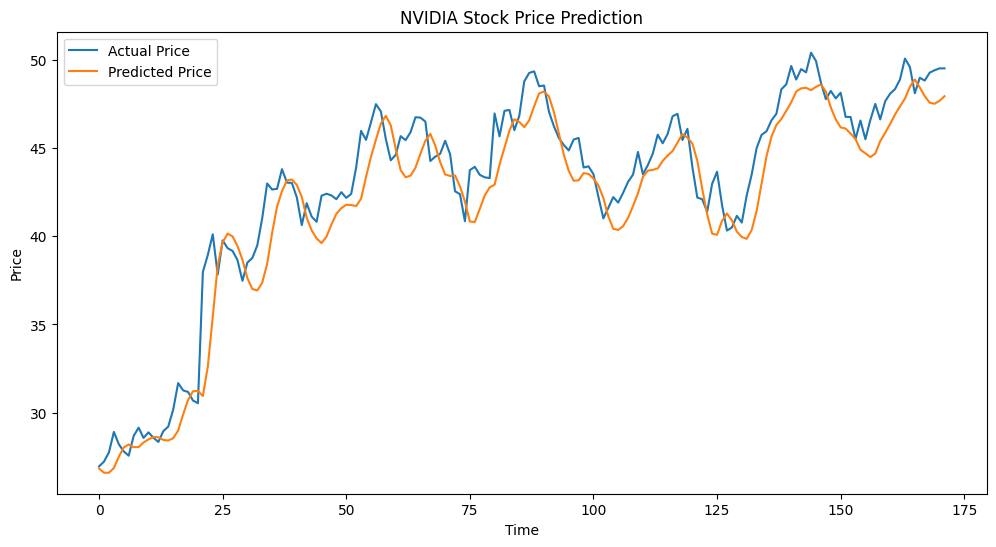

In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras.optimizers import Adam

# Download stock data (example: NVIDIA)
ticker = 'NVDA'
data = yf.download(ticker, start='2016-01-01', end='2024-01-01')

# Remove weekend data (keep only weekdays)
data = data[data.index.dayofweek < 5]

# Data preprocessing
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data[['Close']])  # Only using 'Close' price

# Splitting data into training and testing sets
train_size = int(len(scaled_data) * 0.9)
train_data, test_data = scaled_data[:train_size], scaled_data[train_size:]

# Shaping data for LSTM
def create_dataset(dataset, time_step=30):
    X, y = [], []
    for i in range(time_step, len(dataset)):
        X.append(dataset[i-time_step:i])
        y.append(dataset[i, 0])  # Predicting 'Close' price
    return np.array(X), np.array(y)

time_step = 30
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

# Reshaping data to be suitable for LSTM
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2])
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2])

# Creating LSTM model
model = Sequential()
model.add(LSTM(100, return_sequences=True, input_shape=(time_step, X_train.shape[2])))
model.add(Dropout(0.1))
model.add(LSTM(100, return_sequences=True))
model.add(Dropout(0.1))
model.add(LSTM(50, return_sequences=False))
model.add(Dropout(0.1))
model.add(Dense(50))
model.add(Dense(25))
model.add(Dense(1))

# Compiling the model
learning_rate = 0.001
optimizer = Adam(learning_rate=learning_rate)
model.compile(optimizer=optimizer, loss='mean_squared_error')

# Training the model
model.fit(X_train, y_train, batch_size=32, epochs=50, validation_split=0.1, verbose=1)

# Making predictions
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(np.hstack((predictions, np.zeros((predictions.shape[0], 0)))))[:, 0]

# Comparing with actual test data
y_test_actual = scaler.inverse_transform(np.hstack((y_test.reshape(-1, 1), np.zeros((y_test.shape[0], 0)))))[:, 0]

plt.figure(figsize=(12, 6))
plt.plot(y_test_actual, label='Actual Price')
plt.plot(predictions, label='Predicted Price')
plt.title("NVIDIA Stock Price Prediction")
plt.xlabel("Time")
plt.ylabel("Price")
plt.legend()
plt.show()

## Sliding Window Validation

In [24]:
from sklearn.metrics import mean_squared_error
import math

# Parameters of Sliding window validation
window_size = int(len(scaled_data) * 0.8)  #80% for train
step_size = 100 
time_step = 30  

# Sliding window
window_results = []
start_index = 0

while start_index + window_size + time_step <= len(scaled_data):
    train_data = scaled_data[start_index:start_index + window_size]
    test_data = scaled_data[start_index + window_size - time_step:start_index + window_size + time_step]

    X_train, y_train = create_dataset(train_data, time_step)
    X_test, y_test = create_dataset(test_data, time_step)
    
    #Reshaping
    X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2])
    X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2])

    model = Sequential()
    model.add(LSTM(100, return_sequences=True, input_shape=(time_step, X_train.shape[2])))
    model.add(Dropout(0.1))
    model.add(LSTM(100, return_sequences=True))
    model.add(Dropout(0.1))
    model.add(LSTM(50, return_sequences=False))
    model.add(Dropout(0.1))
    model.add(Dense(50))
    model.add(Dense(25))
    model.add(Dense(1))
    
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
    
    #Train model
    model.fit(X_train, y_train, batch_size=32, epochs=10, verbose=0)

    #Test prediction
    predictions = model.predict(X_test)
    predictions = scaler.inverse_transform(np.hstack((predictions, np.zeros((predictions.shape[0], 2)))))[:, 0]
    y_test_actual = scaler.inverse_transform(np.hstack((y_test.reshape(-1, 1), np.zeros((y_test.shape[0], 2)))))[:, 0]
    
    # Calculate RMSE
    rmse = math.sqrt(mean_squared_error(y_test_actual, predictions))
    window_results.append(rmse)
    
    # Shifting
    start_index += step_size

# Sliding window sonuçlarının ortalaması
average_rmse = np.mean(window_results)
print(f"Sliding Window Average RMSE: {average_rmse}")


c:\Users\oguz\Desktop\LTSM\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 400ms/step


c:\Users\oguz\Desktop\LTSM\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 494ms/step


c:\Users\oguz\Desktop\LTSM\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 416ms/step


c:\Users\oguz\Desktop\LTSM\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 417ms/step
Sliding Window Ortalama RMSE: 1.4632843881484048
